# Project of Machine Learning : Adversarial attacks

### Classic CNN over Cfar10 dataset

#### Loading data and Normalizing

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.optim as optim

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


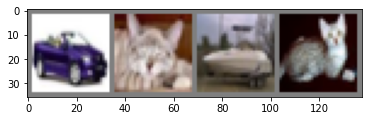

  car   cat  ship   cat


In [ ]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Clean definition of all the iterator over Data

In [ ]:
def train_val_dataset(dataset, val_split=0.1):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets


def data_loading(set_data, repartition_train_valid, b_size, training=False):
  if training :
    print("Loading of Training and Validation sets !")
    datasets = train_val_dataset(set_data, repartition_train_valid)
    dataloaders = {x : torch.utils.data.DataLoader(datasets[x], batch_size=b_size, shuffle=True, num_workers=2) for x in ['train','val']}
    trainloader = dataloaders['train']
    validloader = dataloaders['val']
    return trainloader, validloader
  
  else :
    print("Loading of the Test set !")
    testloader = torch.utils.data.DataLoader(set_data, batch_size=b_size,
                                              shuffle=True, num_workers=2)
    return testloader

#### Class of our CNN

In [ ]:
class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        self.dropout1 = nn.Dropout(p=0.2, inplace=False)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout1(x)
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
      

    def fit(self, train_set, test_set, batch_size, nb_epochs, criterion, learning_r):
      train, valid = data_loading(train_set, 0.1, batch_size, training=True)
      test = data_loading(test_set, 0.1, batch_size, training=False)
      optimizer = optim.SGD(self.parameters(), lr=learning_r, momentum=0.9)
      
      loss_total = []
      valid_loss_total = []
      acc_total = []

      for epoch in range(nb_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        valid_loss = 0.0
        temp = []
        for i, data in enumerate(train, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = self.forward(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          nbr_ref = int(( 5400 / (batch_size / 4) ))

          if i % nbr_ref == nbr_ref - 1:    # print every XXX mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / nbr_ref ))
              
              temp.append(running_loss/nbr_ref)
              running_loss = 0.0
        loss_total.append(np.mean(temp))
        
        with torch.no_grad():
          temp = []
          for i, data in enumerate(valid, 0):
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

            # forward + backward + optimize
            outputs = self.forward(inputs)
            loss_valid = criterion(outputs, labels)

            # print statistics
            valid_loss += loss_valid.item()
            nbr_ref = int(( 600 / (batch_size / 4) ))
            if i % nbr_ref == nbr_ref - 1:    # print every XXX mini-batches
              print('[%d, %5d] valid loss: %.3f' %
                    (epoch + 1, i + 1, valid_loss/nbr_ref))
              
              temp.append(valid_loss/nbr_ref)
              valid_loss = 0.0
          valid_loss_total.append(np.mean(temp))
        
        correct = 0
        total = 0
        with torch.no_grad():
          for data in test :
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = self.forward(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        acc_total.append(100 * correct / total)
      print('Finished Training')
      return acc_total, loss_total, valid_loss_total



    def test(self, test_set, batch_size):
      test = data_loading(test_set, 0.1, batch_size, training=False)
      correct = 0
      total = 0
      confusion_matrix = np.zeros([10,10], int)
      with torch.no_grad():
          for data in test :
              inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
              outputs = self.forward(inputs)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

              for i, l in enumerate(labels):
                  confusion_matrix[l.item(), predicted[i].item()] += 1 

      acc_total = 100 * correct / total
      print('Accuracy of the network on the 10000 test images: %d %%' % (
          acc_total ))
      
      resultats = []
      print('{0:10s} - {1}'.format('Category','Accuracy'))
      for i, r in enumerate(confusion_matrix):
          print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))
          resultats.append('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

      return acc_total, confusion_matrix, resultats

#### Hyperparameters of the CNN

In [ ]:
net = Net()
net.to(DEVICE)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
)

In [ ]:
accuracy, loss, validation_loss = net.fit(trainset, testset, 4, 10, nn.CrossEntropyLoss(), 0.001)

#### Training of our CNN over cifar10

In [ ]:
plt.plot(loss, color='b', label="Training loss")
plt.plot(validation_loss, color='r', label="validation loss")
plt.legend()
plt.xlabel("Epoch id")
plt.ylabel("Loss value")
plt.savefig("Loss_Validloss")
plt.show()

In [ ]:
plt.plot(accuracy, color='orange', label="Current accuracy")
plt.legend()
plt.xlabel("Epoch id")
plt.ylabel("Accuracy value")
plt.savefig("Accuracy", dpi=)
plt.show()

#### Testing and saving this model

In [ ]:
accu, confu_m, results = net.test(testset, 4)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confu_m, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.savefig("Confusion_matrix")
plt.show()

In [ ]:
PATH = './cifar_net_CLASSIC_20epochs.pth'

In [ ]:
torch.save(net.state_dict(), PATH)